In [0]:
%restart_python or dbutils.library.restartPython()

In [0]:
# Install Azure Storage Blob library
%pip install azure-storage-blob

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from azure.storage.blob import BlobServiceClient
from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

In [0]:
from azure.storage.blob import BlobServiceClient
from azure.storage.blob import ContainerClient
from io import StringIO
import pandas as pd

# Extract the account URL and SAS token separately
account_url = "https://rainfallpridictor.blob.core.windows.net"
sas_token = "sp=racwdli&st=2024-06-14T10:42:43Z&se=2024-08-30T18:42:43Z&spr=https&sv=2022-11-02&sr=c&sig=leVZ3NKeNInfmUPcRraX8NZpaL9LdwjBEuYKBpCJh0A%3D"

# Blob service client
blob_service_client = BlobServiceClient(account_url=account_url, credential=sas_token)

# Container name
container_name = "rainfalldata"

# List blobs in the container
container_client = blob_service_client.get_container_client(container_name)
blobs_list = container_client.list_blobs()

print("Blobs in the container:")
for blob in blobs_list:
    print(blob.name)

# Blob name
blob_name = "Rainfall.csv"

# Download blob as text
blob_client = container_client.get_blob_client(blob_name)
blob_data = blob_client.download_blob().content_as_text()



Blobs in the container:
Rainfall.csv


In [0]:
# Data exploration
print(df.shape)
print(df.info())
print(df.describe().T)
print(df.isnull().sum())


(4116, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        4116 non-null   int64  
 1   SUBDIVISION  4116 non-null   object 
 2   YEAR         4116 non-null   int64  
 3   JAN          4116 non-null   float64
 4   FEB          4116 non-null   float64
 5   MAR          4116 non-null   float64
 6   APR          4116 non-null   float64
 7   MAY          4116 non-null   float64
 8   JUN          4116 non-null   float64
 9   JUL          4116 non-null   float64
 10  AUG          4116 non-null   float64
 11  SEP          4116 non-null   float64
 12  OCT          4116 non-null   float64
 13  NOV          4116 non-null   float64
 14  DEC          4116 non-null   float64
 15  ANNUAL       4116 non-null   float64
 16  Jan-Feb      4116 non-null   float64
 17  Mar-May      4116 non-null   float64
 18  Jun-Sep      4116 non-null   float64


In [0]:
# Data cleaning
df.rename(str.strip, axis='columns', inplace=True)
df.columns

for col in df.columns:
    if df[col].isnull().sum() > 0:
        val = df[col].mean()
        df[col] = df[col].fillna(val)

print(df.isnull().sum().sum())


0


(4116, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        4116 non-null   int64  
 1   SUBDIVISION  4116 non-null   object 
 2   YEAR         4116 non-null   int64  
 3   JAN          4116 non-null   float64
 4   FEB          4116 non-null   float64
 5   MAR          4116 non-null   float64
 6   APR          4116 non-null   float64
 7   MAY          4116 non-null   float64
 8   JUN          4116 non-null   float64
 9   JUL          4116 non-null   float64
 10  AUG          4116 non-null   float64
 11  SEP          4116 non-null   float64
 12  OCT          4116 non-null   float64
 13  NOV          4116 non-null   float64
 14  DEC          4116 non-null   float64
 15  ANNUAL       4116 non-null   float64
 16  Jan-Feb      4116 non-null   float64
 17  Mar-May      4116 non-null   float64
 18  Jun-Sep      4116 non-null   float64


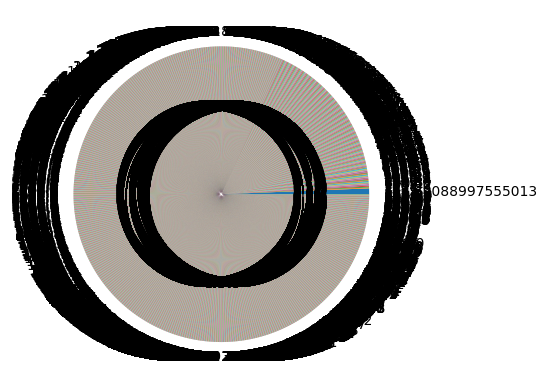

         index    YEAR    JAN    FEB  ...  Jan-Feb  Mar-May  Jun-Sep  Oct-Dec
ANNUAL                                ...                                    
62.3    1834.0  1918.0    0.4    0.0  ...      0.4      4.0     57.4      0.5
92.4    1918.0  2002.0    0.3    2.6  ...      3.0     13.7     67.2      8.6
92.7    2478.0  1987.0    0.0    0.0  ...      0.0      0.5     85.5      6.6
114.4   1821.0  1905.0    6.3    4.8  ...     11.0      2.4    100.1      0.9
117.6   2409.0  1918.0    0.0    0.0  ...      0.0      5.0    112.4      0.2
...        ...     ...    ...    ...  ...      ...      ...      ...      ...
5486.3   112.0  1918.0   10.4   11.0  ...     21.4   1196.9   4121.3    146.7
5553.9  3602.0  1961.0    0.0    0.0  ...      0.0    683.6   4536.9    333.4
5691.4   115.0  1921.0   78.9   54.3  ...    133.2   1136.3   4155.5    266.4
6129.0   132.0  1938.0  144.8  121.6  ...    266.4   1042.3   4534.5    285.8
6331.1   142.0  1948.0   35.6  119.5  ...    155.1   1745.8   42

In [0]:
# Data exploration
print(df.shape)
print(df.info())
print(df.describe().T)
print(df.isnull().sum())

# Using 'ANNUAL' instead of 'rainfall'
df.rename(str.strip, axis='columns', inplace=True)
df.columns

for col in df.columns:
    if df[col].isnull().sum() > 0:
        val = df[col].mean()
        df[col] = df[col].fillna(val)

print(df.isnull().sum().sum())

print(df.head())
print(df.columns)
# Pie chart for 'ANNUAL' column
plt.pie(df['ANNUAL'].value_counts().values,
        labels=df['ANNUAL'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

# Group by 'ANNUAL' and calculate mean 
print(df.groupby('ANNUAL').mean())

# Feature selection
features = list(df.select_dtypes(include=np.number).columns)
features.remove('YEAR') 
print(features)

# Continue with the remaining code


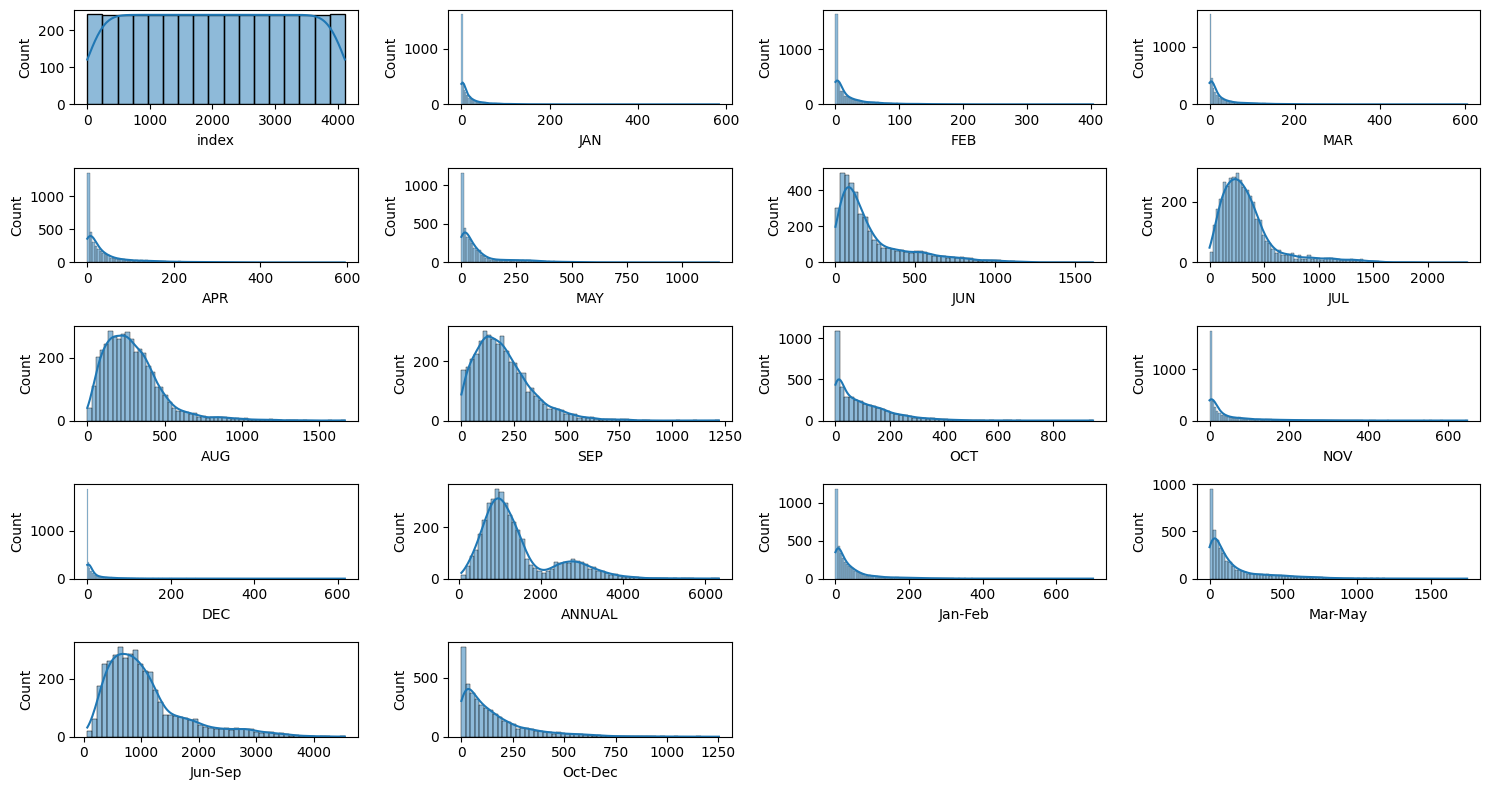

In [0]:
import seaborn as sb
import matplotlib.pyplot as plt

# Determine the grid size dynamically
n_features = len(features)
n_cols = 4
n_rows = (n_features // n_cols) + 1

# Distribution plots
plt.figure(figsize=(15, 8))
for i, col in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sb.histplot(df[col], kde=True)  # Updated to use seaborn's histplot
plt.tight_layout()
plt.show()


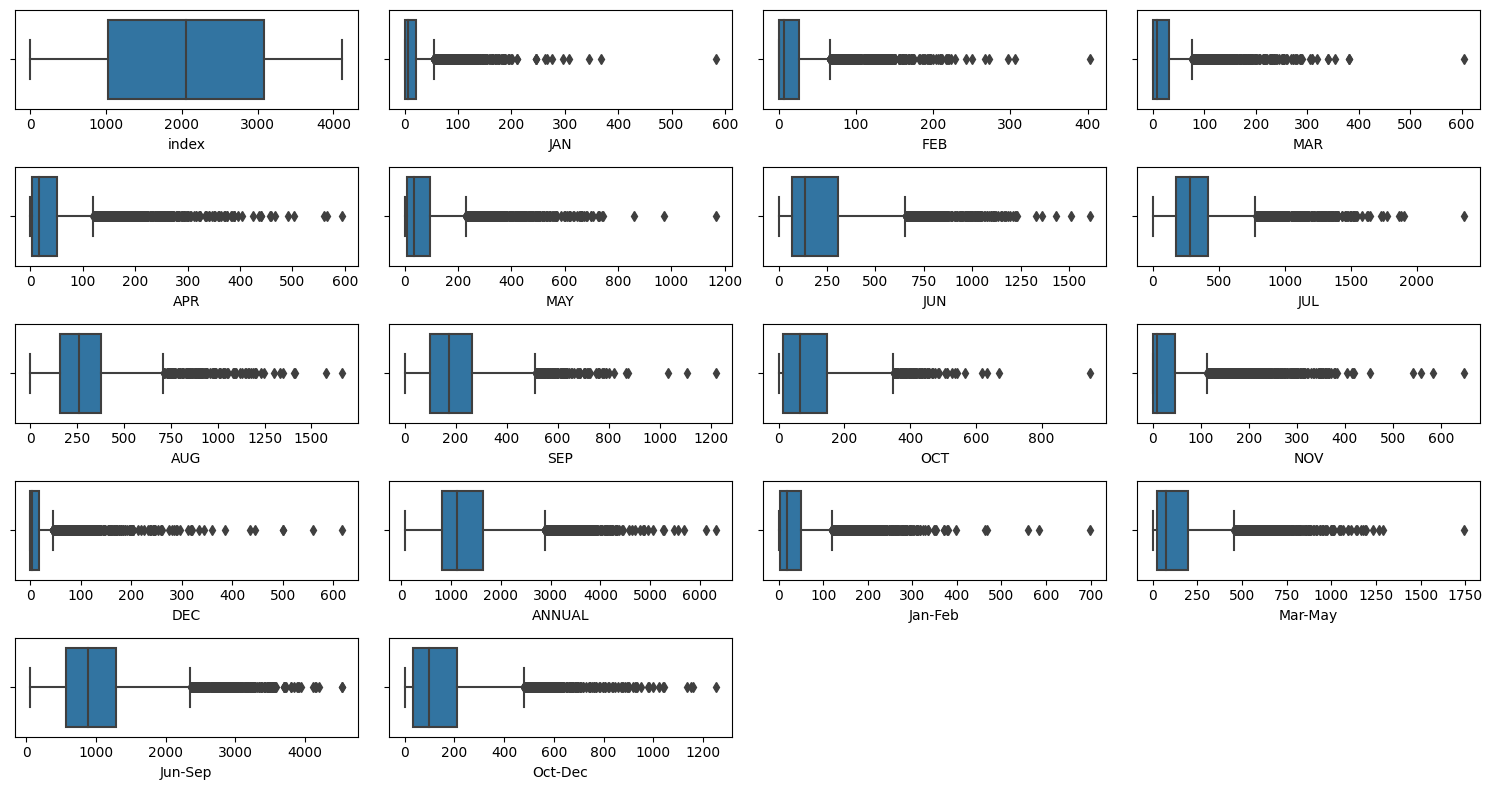

In [0]:
import seaborn as sb
import matplotlib.pyplot as plt

# Calculate rows and columns for subplots
n_features = len(features)
n_cols = 4
n_rows = (n_features // n_cols) + (n_features % n_cols > 0)

# Create subplots
plt.figure(figsize=(15, 8))
for i, col in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sb.boxplot(x=df[col])
plt.tight_layout()
plt.show()


Index(['index', 'SUBDIVISION', 'YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY',
       'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL', 'Jan-Feb',
       'Mar-May', 'Jun-Sep', 'Oct-Dec'],
      dtype='object')


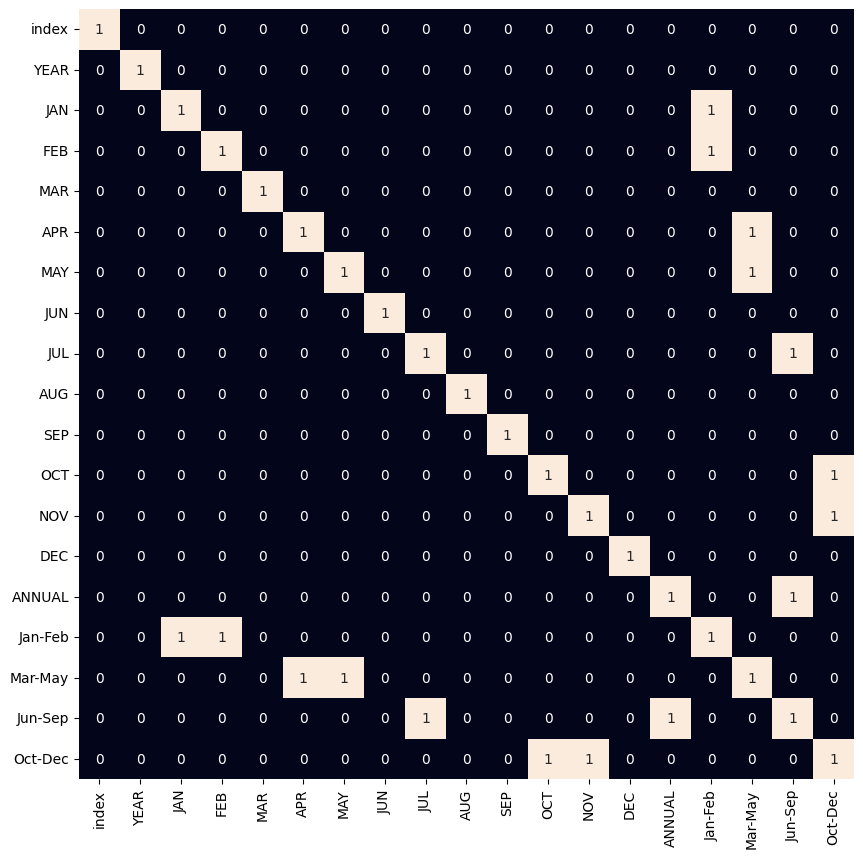

In [0]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Print the columns to inspect them
print(df.columns)

# Encoding categorical data if necessary
df.replace({'yes': 1, 'no': 0}, inplace=True)

# Heatmap for correlations
plt.figure(figsize=(10, 10))
sb.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.show()

# Feature-target split
columns_to_drop_in_features = ['index', 'SUBDIVISION', 'YEAR', 'ANNUAL']
features = df.drop(columns=columns_to_drop_in_features, errors='ignore')
target = df['ANNUAL']

# Splitting the dataset without stratification (since it's a regression task)
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=2)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Continue with your regression model training here


Index(['index', 'SUBDIVISION', 'YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY',
       'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL', 'Jan-Feb',
       'Mar-May', 'Jun-Sep', 'Oct-Dec'],
      dtype='object')


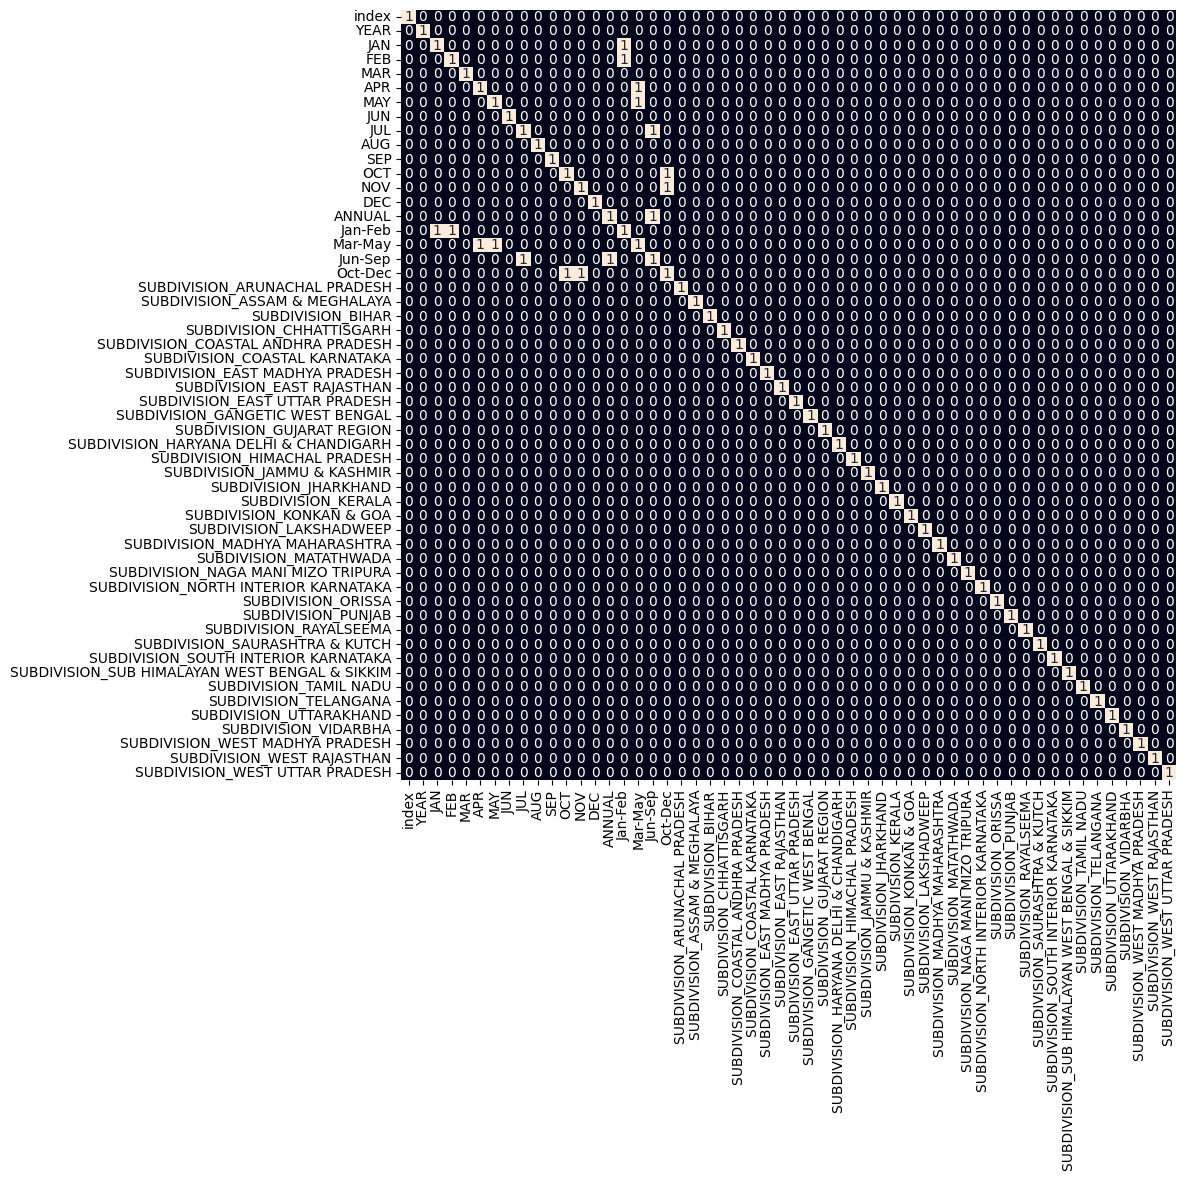

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

LogisticRegression : 
Training Accuracy (ROC AUC):  0.9965439586166914
Validation Accuracy (ROC AUC):  0.9985777777777778



Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

XGBClassifier : 
Training Accuracy (ROC AUC):  1.0
Validation Accuracy (ROC AUC):  0.9872000000000001



Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

SVC : 
Training Accuracy (ROC AUC):  0.9801110392650896
Validation Accuracy (ROC AUC):  0.9628444444444444



In [0]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import metrics
import numpy as np

# Print the columns to inspect them
print(df.columns)

# One-Hot Encoding for categorical columns (if any)
df = pd.get_dummies(df, columns=['SUBDIVISION'], drop_first=True)

# Encoding other categorical data if necessary
df.replace({'yes': 1, 'no': 0}, inplace=True)

# Heatmap for correlations
plt.figure(figsize=(10, 10))
sb.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.show()

# Feature-target split
columns_to_drop_in_features = ['index', 'YEAR', 'ANNUAL']
features = df.drop(columns=columns_to_drop_in_features, errors='ignore')
target = df['ANNUAL']

# Splitting the dataset without stratification (since it's a regression task)
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=2)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert target to a binary classification problem (if required)
# For this example, let's create a binary classification problem
# assuming rainfall above median as 1 and below or equal as 0
Y_train_binary = (Y_train > Y_train.median()).astype(int)
Y_val_binary = (Y_val > Y_val.median()).astype(int)

# Model training and evaluation
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf', probability=True)]

for model in models:
    model.fit(X_train, Y_train_binary)
    print(f'{model.__class__.__name__} : ')

    train_preds = model.predict_proba(X_train)
    print('Training Accuracy (ROC AUC): ', metrics.roc_auc_score(Y_train_binary, train_preds[:, 1]))

    val_preds = model.predict_proba(X_val)
    print('Validation Accuracy (ROC AUC): ', metrics.roc_auc_score(Y_val_binary, val_preds[:, 1]))
    print()


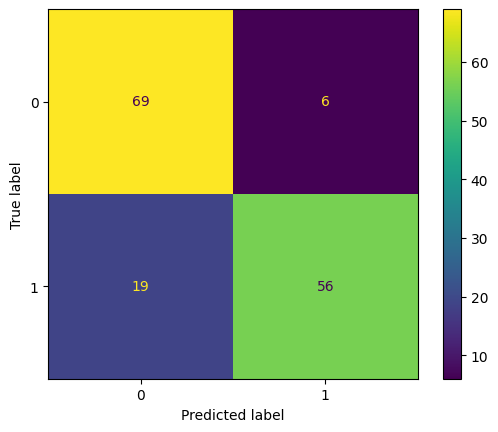

              precision    recall  f1-score   support

           0       0.78      0.92      0.85        75
           1       0.90      0.75      0.82        75

    accuracy                           0.83       150
   macro avg       0.84      0.83      0.83       150
weighted avg       0.84      0.83      0.83       150



In [0]:
# Confusion matrix for the best model (SVC in this case)
best_model = models[2]  # SVC model
Y_val_pred = best_model.predict(X_val)

conf_matrix = metrics.confusion_matrix(Y_val_binary, Y_val_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

# Classification report
print(metrics.classification_report(Y_val_binary, Y_val_pred))